## RECONOCIMIENTO DE PATRONES - TYPES OF GLASS

## READ THE DATA

In [1]:
import pandas as pd


In [2]:
input_folder = "./input/"
glass_csv = "glassInputs.csv"
targets_csv = "glassTargets.csv"


In [3]:
def read_data(file_name):
    data = pd.read_csv(file_name)
    return data


glass_data = read_data(input_folder + glass_csv)
targets_data = read_data(input_folder + targets_csv)


---
---

## DEAP CONFIGURATION

In [4]:
import operator
import math
import random

# Import deap gp and tools
from deap import gp, base, tools, creator, algorithms


In [5]:
def protectedDiv(left, right):
    return 1 if right == 0 else left / right


#### INDIVIDUAL

In [6]:
def config_individual():
    # Create primitive set
    pset = gp.PrimitiveSet("MAIN", 1)

    # Add all primitives to the primitive set
    pset.addPrimitive(operator.add, 2)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    pset.addPrimitive(protectedDiv, 2)
    pset.addPrimitive(operator.neg, 1)
    pset.addPrimitive(math.cos, 1)
    pset.addPrimitive(math.sin, 1)

    """
    A constant (random) value to include in the tree is added: it allows to include in the functions other operands.
    """
    pset.addEphemeralConstant("rand101", lambda: random.randint(-1, 1))

    """
    An argument is added for the function to be evaluated (in our problem there is only one: the 'x' of the function). 
    That is, given an x, you are asked to calculate the corresponding y.
    If the function needs more input parameters, they are added here
    """
    pset.renameArguments(ARG0="x")

    return pset


#### TEST INDIVIDUAL

In [7]:
def test_individual():
    pset = config_individual()
    expr = gp.genFull(pset, min_=1, max_=3)
    tree = gp.PrimitiveTree(expr)
    print(tree)


## POPULATION CONFIGURATION

#### POPULATION

In [8]:
def config_population(toolbox):
    # Create fitness and individual.
    if not hasattr(creator, "FitnessMin"):
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", gp.PrimitiveTree,
                       fitness=creator.FitnessMin)

    pset = config_individual()

    # Register expr, individual, population and compile in toolbox
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
    toolbox.register("individual", tools.initIterate,
                     creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)

    return pset


#### TEST POPULATION

In [9]:
def test_population():
    toolbox = base.Toolbox()
    config_population(toolbox)
    pop = toolbox.population(n=10)

    for ind in pop:
        print(gp.PrimitiveTree(ind))


---
---

#### DATA (TEMPORAL)

In [10]:
def fCuarta():
    entradas = [x/10. for x in range(-10, 10)]
    salidas = [x**4 - x**3 - x**2 - x for x in entradas]

    return entradas, salidas


#### TEST DATA (TEMPORAL)

In [11]:
def prueba():
    entradas, salidas = fCuarta()

    for x, y in zip(entradas, salidas):
        print("x=", x, "y=", y)


## EVALUATION

In [12]:
def eval_eq(toolbox, individual):
    # Se calcula el error cuadrático medio que comete la función
    # al evaluarse sobre los diferentes datos
    # El ECM se calcula como:

    entradas, salidas = fCuarta()
    func = toolbox.compile(expr=individual)

    sqerrors = []
    for x, y in zip(entradas, salidas):
        sqerrors.append((func(x) - y)**2)

    return (math.fsum(sqerrors) / len(entradas)),


#### PLOT TREE

In [13]:
import networkx as nx


In [14]:
def plot_tree(individual):
    nodes, edges, labels = gp.graph(individual)

    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    
    nx.draw_networkx_labels(g, pos=nx.spring_layout(g), labels=labels)
    nx.draw(g, pos=nx.spring_layout(g))
    
    plt.show()


#### TEST EVALUATION

In [15]:
def test_evaluation():
    toolbox = base.Toolbox()
    config_population(toolbox)
    ind = toolbox.individual()

    tree = gp.PrimitiveTree(ind)
    print(tree)
    print(ind.fitness.valid)

    ind.fitness.values = eval_eq(toolbox, ind)

    print(ind.fitness.valid)
    print(ind.fitness)


---
---

## STATS

In [16]:
import matplotlib.pyplot as plt
import numpy as np

In [17]:
def config_stats():
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    return stats


In [18]:
def show_stats(log):
    gen = log.select("gen")
    avgs = log.select("avg")

    _, ax1 = plt.subplots()

    _ = ax1.plot(gen, avgs, "r-", label="Average Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness", color="b")

    plt.show()
    

---
---

## EVOLUTION CYCLE

In [19]:
def config_algorithm(toolbox, pset):
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

    toolbox.decorate("mate", gp.staticLimit(
        key=operator.attrgetter("height"), max_value=17))
    toolbox.decorate("mutate", gp.staticLimit(
        key=operator.attrgetter("height"), max_value=17))

    toolbox.register("evaluate", eval_eq, toolbox)
    

In [20]:

def make_evolution(plot_stats=False):
    toolbox = base.Toolbox()

    pset = config_population(toolbox)
    stats = config_stats()

    config_algorithm(toolbox, pset)

    pop = toolbox.population(n=50)

    CXPB, MUTPB, NGEN = 0.5, 0.2, 30

    pop, logbook = algorithms.eaSimple(
        pop, toolbox, verbose=False, stats=stats,
        cxpb=CXPB, mutpb=MUTPB, ngen=NGEN)

    best = tools.selBest(pop, 1)[0]

    if plot_stats:
        print("Best individual is %s, %s" % (best, best.fitness.values))
        show_stats(logbook)
        plot_tree(best)

    return logbook, best


#### TEST EVOLUTION CYCLE

Best individual is neg(add(x, sin(sin(sin(x))))), (0.0766737630079716,)


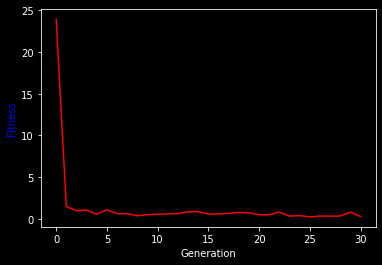

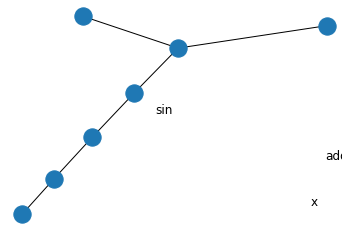

([{'gen': 0,
   'nevals': 50,
   'avg': 23.936299800282622,
   'std': 151.17337566336062,
   'min': 0.17322083300000002,
   'max': 1081.9214643267564},
  {'gen': 1,
   'nevals': 31,
   'avg': 1.4813941695254456,
   'std': 2.035003309601665,
   'min': 0.17322083300000002,
   'max': 13.842558144665407},
  {'gen': 2,
   'nevals': 21,
   'avg': 0.9697051203281459,
   'std': 1.1627617022340913,
   'min': 0.17322083300000002,
   'max': 6.399860833},
  {'gen': 3,
   'nevals': 28,
   'avg': 1.0412145800522985,
   'std': 1.978693203620698,
   'min': 0.101560833,
   'max': 13.842558144665407},
  {'gen': 4,
   'nevals': 23,
   'avg': 0.558811482179633,
   'std': 0.6353192034778357,
   'min': 0.101560833,
   'max': 2.326540833},
  {'gen': 5,
   'nevals': 36,
   'avg': 1.0783348876680376,
   'std': 2.081514418057673,
   'min': 0.101560833,
   'max': 13.354218144665406},
  {'gen': 6,
   'nevals': 26,
   'avg': 0.6231943447436877,
   'std': 0.9223172536005806,
   'min': 0.101560833,
   'max': 4.40820

In [21]:
make_evolution(plot_stats=True)
